# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scipy.interpolate import interp1d
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
numerical = ['num_likes', 
             'num_sent', 
             'sent_avg_length', 
             'num_words', 
             'num_unique_words', 
             'unique_words_percent',
             'words_exist_per_cent',
             'emotion_anger', 'emotion_fear', 'emotion_joy', 'emotion_love', 
             'emotion_sadness', 'emotion_surprise', 
             'sentiment_POSITIVE_no_prepro', 'sentiment_NEGATIVE_no_prepro', 
             'sentiment_hf_text']

txt_features = ['text_str', 'text_str_lem']

In [3]:
feats_to_keep = numerical + txt_features

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df = pd.read_csv("drive/MyDrive/story_data_new_feats.csv", 
                 usecols=feats_to_keep)

In [8]:
target = 'num_likes'

# Preprocessing to get general features

In [9]:
numerical.remove('num_likes')

In [10]:
X = df[numerical+txt_features]
y = df[target].copy()

In [11]:
# turn y into labels 0 and 1, given a threshold
threshold = np.quantile(y, 0.7)

In [12]:
from sklearn.preprocessing import Binarizer

bn = Binarizer(threshold=threshold).fit(df[[target]])
y = bn.transform(df[[target]])

In [13]:
# log transform for relevant distributions
for var_to_log in ['sent_avg_length', 'num_unique_words', 'emotion_love']:
    X.loc[:, var_to_log] = X.loc[:, var_to_log].apply(np.log1p)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


# Split

In [14]:
from sklearn.model_selection import train_test_split

test_size = 20/100

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size, 
                                                    random_state=42, 
                                                   stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14598, 17), (3650, 17), (14598, 1), (3650, 1))

In [15]:
# we first infer the following data on the transformer model
X_train_tr = X_train[['text_str']]
X_test_tr = X_test[['text_str']]

In [16]:
# we then combine the results (the probits) with the general features
X_train_gen = X_train[numerical]
X_test_gen = X_test[numerical]

In [17]:
# and with the TF/IDF features
X_train_tfidf = X_train[['text_str_lem']]
X_test_tfidf = X_test[['text_str_lem']]

In [18]:
y_train = y_train.ravel()
y_test = y_test.ravel()

# Split texts for transformer

In [19]:
nb_splits = 3
cols = ['split_'+ str(i) for i in range(1, nb_splits+1)]

def split_text(row):
  nb_splits

  l = len(row['text_str'])
  chars = int(l/nb_splits)

  for i, col in zip(range(0, l, chars), cols):  
      row[col] = row['text_str'][ i : i+chars];  
  return row

In [21]:
from tqdm import tqdm
tqdm.pandas()
X_train_tr = X_train_tr.progress_apply(split_text, axis=1)
X_test_tr = X_test_tr.progress_apply(split_text, axis=1)

100%|██████████| 3650/3650 [00:05<00:00, 677.51it/s]


In [22]:
X_train_tr['story_id'] = X_train_tr.index.tolist()
X_test_tr['story_id'] = X_test_tr.index.tolist()

In [23]:
X_train_tr = X_train_tr.melt(id_vars=['story_id'], value_vars=cols)
X_test_tr = X_test_tr.melt(id_vars=['story_id'], value_vars=cols)

In [24]:
len(X_train_tr)

43794

In [25]:
X_train_tr = X_train_tr.sort_values(by=['story_id', 'variable']).reset_index(drop=True)[['value', 'story_id']]
X_test_tr = X_test_tr.sort_values(by=['story_id', 'variable']).reset_index(drop=True)[['value', 'story_id']]

In [26]:
X_train_tr_index = X_train_tr.story_id
X_test_tr_index = X_test_tr.story_id

# import transformer model

In [27]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.0 MB/s 
     |████████████████████████████████| 6.6 MB 57.1 MB/s 
     |████████████████████████████████| 101 kB 14.0 MB/s 
     |████████████████████████████████| 596 kB 58.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [28]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [29]:
from transformers import TFAutoModelForSequenceClassification
model = TFAutoModelForSequenceClassification.from_pretrained("ilan541/OncUponTim")

Downloading:   0%|          | 0.00/664 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at ilan541/OncUponTim.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


# Tokenize data

In [30]:
%%time
max_length = 512
X_train_tr = tokenizer(X_train_tr.value.tolist(), 
                    truncation=True, 
                    padding='max_length', 
                    max_length=max_length)

CPU times: user 1min 51s, sys: 2.61 s, total: 1min 53s
Wall time: 1min 44s


In [31]:
len(X_train_tr['input_ids'])

43794

In [32]:
%%time
X_test_tr = tokenizer(X_test_tr.value.tolist(), 
                   truncation=True, 
                   padding='max_length', 
                   max_length=max_length)

CPU times: user 27.7 s, sys: 585 ms, total: 28.3 s
Wall time: 17.8 s


In [33]:
X_train_tr = [np.array(X_train_tr.input_ids)]
X_test_tr = [np.array(X_test_tr.input_ids)]

# Inference

In [34]:
X_train_tr[0].shape

(43794, 512)

In [35]:
%%time
y_pred_train_tr = model.predict(X_train_tr, verbose=1)

1369/1369 [==============================] - 1767s 1s/step
CPU times: user 3min 7s, sys: 41.1 s, total: 3min 48s
Wall time: 29min 26s


In [36]:
%%time
y_pred_test_tr = model.predict(X_test_tr, verbose=1)

343/343 [==============================] - 441s 1s/step
CPU times: user 44.3 s, sys: 10.5 s, total: 54.8 s
Wall time: 7min 21s


In [37]:
from scipy.special import softmax

def get_mean_pred(X_index, model, y_pred):
  y_pred_df = pd.DataFrame()


  y_pred_df['story_id'] = X_index.values
  y_pred_df['y_pred_0'] = y_pred.logits[:,0]
  y_pred_df['y_pred_1'] = y_pred.logits[:,1]

  y_pred_all = np.array(y_pred_df[['y_pred_0', 'y_pred_1']])
  y_pred_df['y_pred_tr'] = np.argmax(y_pred_all, axis=1)

  y_pred_all = softmax(y_pred_all)

  

  return y_pred_df.groupby('story_id').mean()

In [38]:
y_pred_train = get_mean_pred(X_train_tr_index, model, y_pred_train_tr)
y_pred_test = get_mean_pred(X_test_tr_index, model, y_pred_test_tr)

In [46]:
np.unique(y_pred_test.y_pred_tr, return_counts=True)

(array([0.        , 0.33333333, 0.66666667, 1.        ]),
 array([2961,  284,  178,  227]))

In [45]:
np.unique(y_pred_train.y_pred_tr, return_counts=True)

(array([0.        , 0.33333333, 0.66666667, 1.        ]),
 array([11762,  1095,   773,   968]))

In [48]:
X_train_gen.shape, y_pred_train.shape

((14598, 15), (14598, 3))

In [49]:
# # need to normalize the transformer predictions ?
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# y_pred_train_tr = pd.DataFrame(scaler.fit_transform(y_pred_train_tr), columns=y_pred_train_tr.columns)
# y_pred_test_tr = pd.DataFrame(scaler.transform(y_pred_test_tr), columns=y_pred_test_tr.columns)


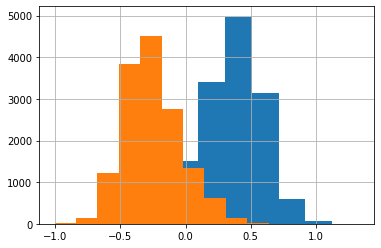

In [50]:
# visualization of the transformer predictions (hist)
y_pred_train.y_pred_0.hist()
y_pred_train.y_pred_1.hist()

In [51]:
X_train_trans = y_pred_train.reset_index(drop=True)
X_test_trans = y_pred_test.reset_index(drop=True)

# Help functions

In [52]:
def display_model_results(model, X_train, X_test, y_train, y_test, name_model):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # display R2
  print(f'R2 on train set: {model.score(X_train, y_train)}')
  print(f'R2 on test set: {model.score(X_test, y_test)}')
  print('\n')

  # classification report
  print(classification_report(y_test, y_pred))
  print('\n')

  # confusion matric
  print('Confusion matrix:')
  print(confusion_matrix(y_test, y_pred))
  print('\n')

  # roc
  y_probs = model.predict_proba(X_test)[:,1]
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
  auc = roc_auc_score(y_test, y_probs)

  plt.figure(figsize=(10,10))
  plt.plot(fpr, tpr, label=f'{name_model}, AUC={auc:.4f}')
  plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="no model. AUC=.5")
  plt.title("Receiver operating characteristic ")
  plt.xlabel('rate of false positives')
  plt.ylabel('rate of true positives')
  plt.legend(loc='best')
  plt.show()
  print('\n')

  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

  print(f'{tp*100/(tp+fn):.2f}% of the good stories are rightly identified.')
  print(f'{fp*100/(fp+tn):.2f}% of the bad stories are identified as good ones.')

  print('\n')


  # feature importance
  try:
    cols = [x for _, x in sorted(zip(model.coef_.tolist()[0], X_train.columns))]
    plt.figure(figsize=(15,15))
    for col, coef in zip(cols, sorted(model.coef_.tolist()[0])):
      plt.barh(col, coef)
  except AttributeError:
    print('No feature importance')
  return model


In [53]:
def play_with_threshold(recall_value, X_test, y_test, model, name):
  """
  Model must be trained
  """
  y_probs = model.predict_proba(X_test)[:,1]
  precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

  x = np.linspace(0,1, num=len(precision))
  y = interp1d(recall, precision)
  precision_value = y(recall_value)
  plt.figure(figsize=(10,10))
  plt.plot(recall, precision, label=name)
  plt.title("precision-recall curve")
  plt.plot(x, [precision_value]*len(recall), label=f'{precision_value:.2f}')
  plt.axvline(recall_value, label=f'{recall_value:.2f}')
  plt.xlabel('recall')
  plt.ylabel('precision')
  plt.legend()
  plt.show()

  if len(thresholds)<len(recall):
    thresholds = np.append(thresholds,0)
  y_thresholds = interp1d(recall, thresholds)
  threshold_value = y_thresholds(recall_value)
  print('\n')
  print(f'When recall is equal to {recall_value:.2f}, precision is equal to {precision_value:.4f},\
and the threshold is equal to {threshold_value:.2f}.')
  f1 = 2*(recall_value*precision_value)/(recall_value+precision_value)
  print(f'f1 is equal to {f1:.4f}')
  
  return threshold_value


In [54]:
def conf_matrix(model, threshold_proba, X_test, y_test):
  p = threshold_proba
  y_probs = model.predict_proba(X_test)[:,1]

  y_pred = (y_probs >= p).astype(int)
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

  print(f'{tp*100/(tp+fn):.2f}% of the good stories are rightly identified.')
  print(f'{fp*100/(fp+tn):.2f}% of the bad stories are identified as good ones.')
  print('\n')
  print(f"Confusion matrix when p={p:.2f}:")
  print(confusion_matrix(y_test, y_pred))


In [55]:
def plot_rocs(names, models, X_test, y_test):
  
  plt.figure(figsize=(10, 7))
  
  for name, model in zip(names, models):
    y_probs = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
    auc = roc_auc_score(y_test, y_probs)

    plt.plot(fpr, tpr, label=f'{name}, AUC={auc:.4f}')
      
  plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="no model. AUC=.5")
  plt.title('ROC curves\n(Receiver Operating Characteristic)')
  plt.xlabel('rate of false positives\nFPR')
  plt.ylabel('rate of true positives\nTPR')
  plt.legend(loc='best')
  plt.show()

# General features - train model

## Preprocessing

In [56]:
# feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_gen = pd.DataFrame(scaler.fit_transform(X_train_gen), columns=X_train_gen.columns)
X_test_gen = pd.DataFrame(scaler.transform(X_test_gen), columns=X_train_gen.columns)

X_train_gen.shape, X_test_gen.shape

((14598, 15), (3650, 15))

###add the predictions of the transformer as features to the general feature model 

In [57]:
X_train_gen.shape, X_train_trans.shape

((14598, 15), (14598, 3))

In [58]:
X_train_gen_tr = pd.concat([X_train_gen, X_train_trans], axis=1)
X_test_gen_tr = pd.concat([X_test_gen, X_test_trans], axis=1)


In [59]:
scaler = StandardScaler()
X_train_gen_tr = pd.DataFrame(scaler.fit_transform(X_train_gen_tr), columns=X_train_gen_tr.columns)
X_test_gen_tr = pd.DataFrame(scaler.transform(X_test_gen_tr), columns=X_train_gen_tr.columns)


In [61]:
np.unique(X_train_gen_tr.y_pred_tr, return_counts=True)

(array([-0.44176245,  0.72123993,  1.88424231,  3.0472447 ]),
 array([11762,  1095,   773,   968]))

In [63]:
X_train_gen_tr[X_train_gen_tr.y_pred_tr==np.max(X_train_gen_tr.y_pred_tr)].head(5)

,num_sent,sent_avg_length,num_words,num_unique_words,unique_words_percent,words_exist_per_cent,emotion_anger,emotion_fear,emotion_joy,emotion_love,emotion_sadness,emotion_surprise,sentiment_POSITIVE_no_prepro,sentiment_NEGATIVE_no_prepro,sentiment_hf_text,y_pred_0,y_pred_1,y_pred_tr
4,2.413924,-0.547556,1.990651,1.487503,-1.302965,-0.111114,0.217680,1.172408,-0.762181,-0.740302,-0.443924,-0.753419,0.035733,-0.407325,-0.719596,-2.979334,2.996222,3.047245
9,-0.344170,0.288549,-0.154987,0.529289,1.041749,0.312240,-0.285566,-0.307025,0.040986,-0.662374,1.138914,0.714228,0.372608,-0.832483,-0.719596,-1.837406,1.684713,3.047245
41,-0.509656,-0.675963,-0.951508,-1.068870,0.394037,0.671522,0.623710,1.262639,-0.695282,-1.063140,-1.557975,0.052191,0.180302,-0.589782,-0.719596,-1.720186,1.662897,3.047245
66,-0.840627,-0.172684,-1.073471,-1.144705,0.791976,0.242880,-0.738028,-1.239158,2.222188,1.078271,-1.241401,-0.753419,0.035733,-0.407325,1.390410,-1.688363,1.718035,3.047245
73,-0.693529,-0.089558,-0.882245,-0.843846,0.590122,-0.771902,-0.772751,-0.020607,1.235466,-1.063140,-0.576245,0.150437,-1.105337,1.032775,-0.719596,-1.922893,1.952284,3.047245


## Predictions

### log regression

R2 on train set: 0.7098917659953419
R2 on test set: 0.7131506849315068


              precision    recall  f1-score   support

           0       0.71      0.99      0.83      2592
           1       0.60      0.03      0.06      1058

    accuracy                           0.71      3650
   macro avg       0.66      0.51      0.45      3650
weighted avg       0.68      0.71      0.61      3650



Confusion matrix:
[[2570   22]
 [1025   33]]




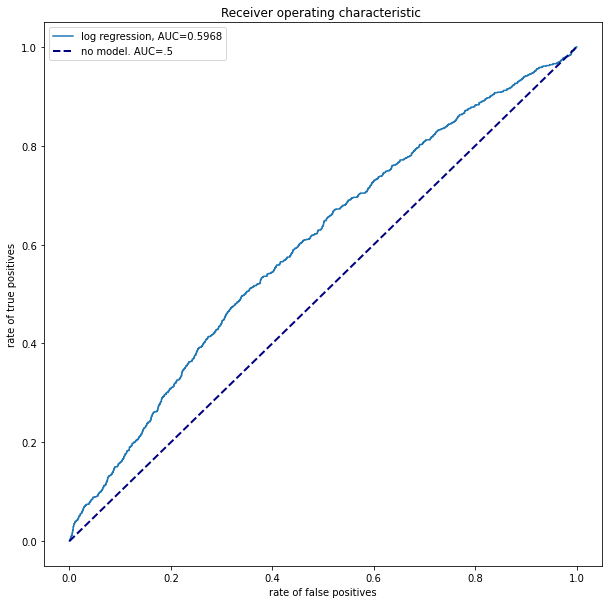



3.12% of the good stories are rightly identified.
0.85% of the bad stories are identified as good ones.




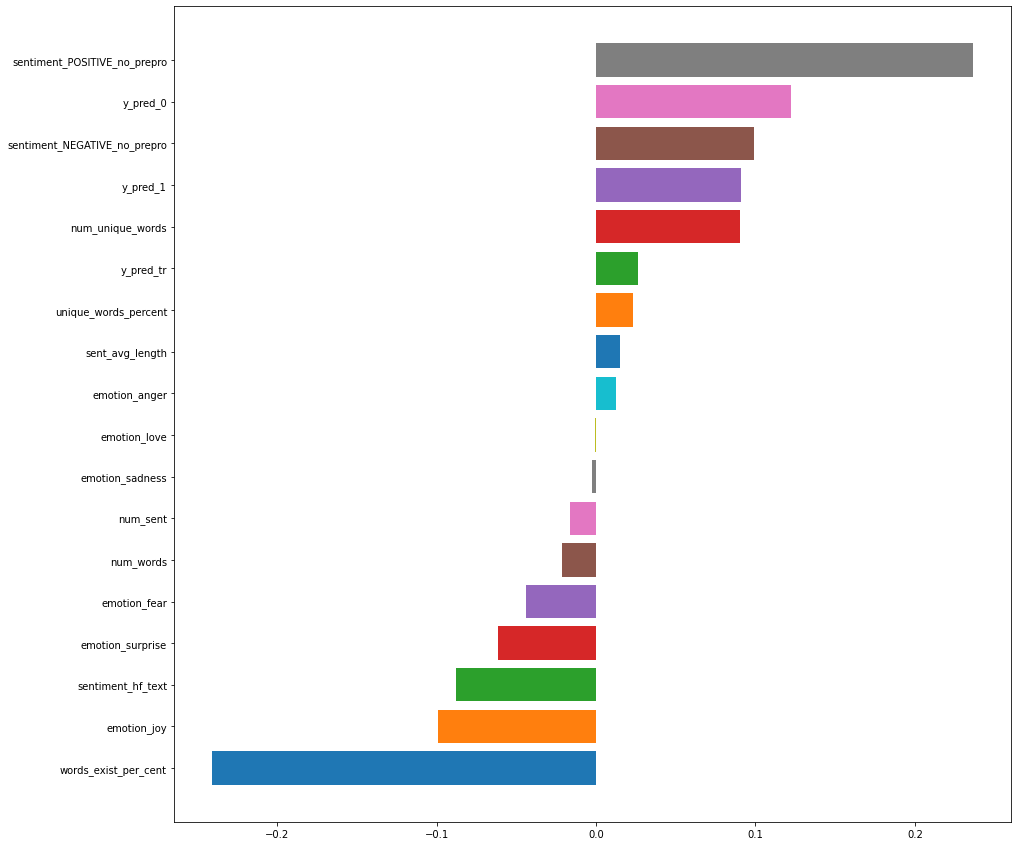

In [65]:
from sklearn.linear_model import LogisticRegression
clf_log_gen_tr = display_model_results(LogisticRegression(random_state=0), 
                      X_train_gen_tr, X_test_gen_tr, y_train, y_test, 
                      'log regression')


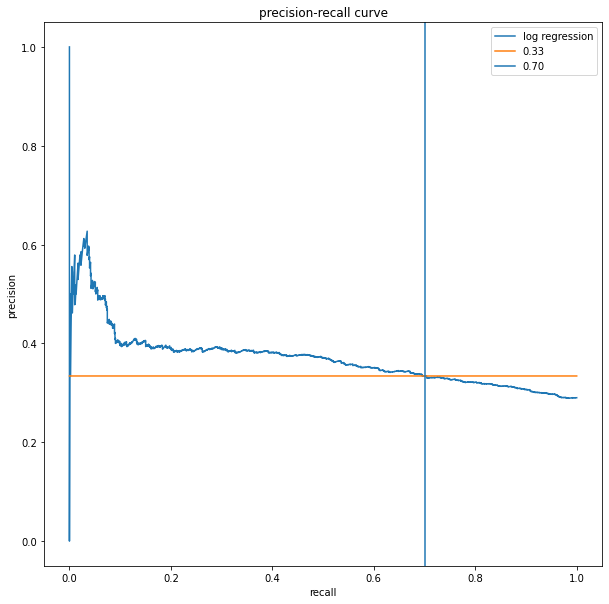



When recall is equal to 0.70, precision is equal to 0.3341,and the threshold is equal to 0.26.
f1 is equal to 0.4523


In [70]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_gen_tr, y_test, 
                                  clf_log_gen_tr, 'log regression')

In [71]:
conf_matrix(clf_log_gen_tr, p_threshold, X_test_gen_tr, y_test)

69.94% of the good stories are rightly identified.
56.94% of the bad stories are identified as good ones.


Confusion matrix when p=0.26:
[[1116 1476]
 [ 318  740]]


### KNN

k that minimizes the validation set error: 16


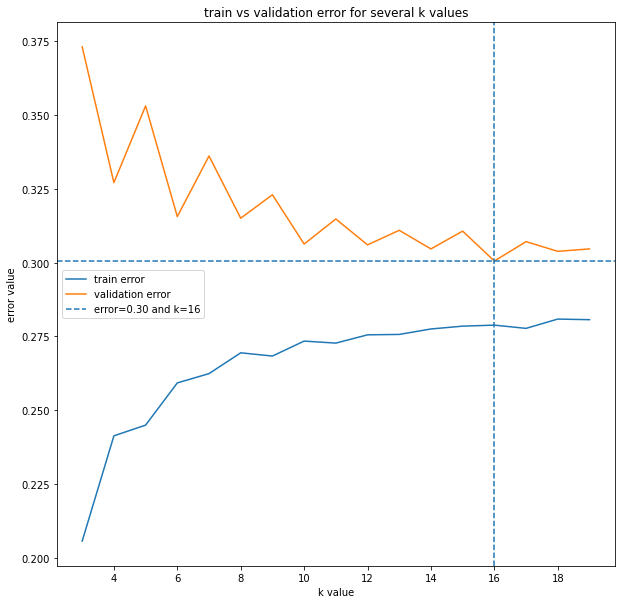

In [93]:
errors_train = []
errors_val = []
k_values = list(range(3, 20))

for k in k_values:
  neigh = KNeighborsClassifier(k)
  neigh.fit(X_train_gen_tr, y_train)
  error_train = 1 - neigh.score(X_train_gen_tr, y_train) 
  error_val   = 1 - neigh.score(X_test_gen_tr, y_test) 
  errors_train.append(error_train)
  errors_val.append(error_val)

k_best = k_values[errors_val.index(min(errors_val))]
plt.figure(figsize=(10,10))
plt.plot(k_values, errors_train, label='train error')
plt.plot(k_values, errors_val, label='validation error')
plt.axhline(y = min(errors_val), linestyle = '--', label=f'error={min(errors_val):.2f} and k={k_best}')
plt.axvline(x=k_best, linestyle = '--')
plt.xlabel('k value')
plt.ylabel('error value')
plt.title('train vs validation error for several k values')
plt.legend()

print(f'k that minimizes the validation set error: {k_best}')


R2 on train set: 0.7211946842033156
R2 on test set: 0.6994520547945206


              precision    recall  f1-score   support

           0       0.71      0.96      0.82      2592
           1       0.38      0.06      0.10      1058

    accuracy                           0.70      3650
   macro avg       0.55      0.51      0.46      3650
weighted avg       0.62      0.70      0.61      3650



Confusion matrix:
[[2493   99]
 [ 998   60]]




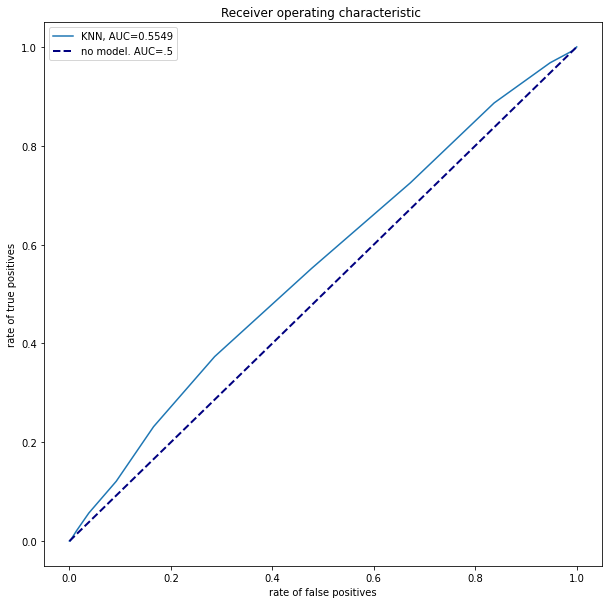



5.67% of the good stories are rightly identified.
3.82% of the bad stories are identified as good ones.


No feature importance


In [94]:
clf_knn_gen_tr = display_model_results(KNeighborsClassifier(k_best), 
                      X_train_gen_tr, X_test_gen_tr, y_train, y_test, 
                      'KNN')


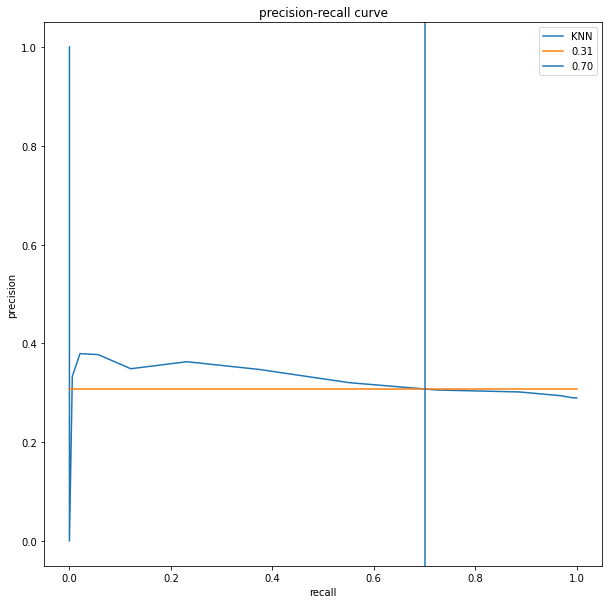



When recall is equal to 0.70, precision is equal to 0.3078,and the threshold is equal to 0.26.
f1 is equal to 0.4276


In [95]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_gen_tr, y_test, 
                                  clf_knn_gen_tr, 'KNN')

In [98]:
conf_matrix(clf_knn_gen_tr, p_threshold, X_test_gen_tr, y_test)

55.20% of the good stories are rightly identified.
47.76% of the bad stories are identified as good ones.


Confusion matrix when p=0.26:
[[1354 1238]
 [ 474  584]]


### SVC

R2 on train set: 0.7146184408823126
R2 on test set: 0.709041095890411


              precision    recall  f1-score   support

           0       0.71      1.00      0.83      2592
           1       0.17      0.00      0.00      1058

    accuracy                           0.71      3650
   macro avg       0.44      0.50      0.42      3650
weighted avg       0.55      0.71      0.59      3650



Confusion matrix:
[[2587    5]
 [1057    1]]




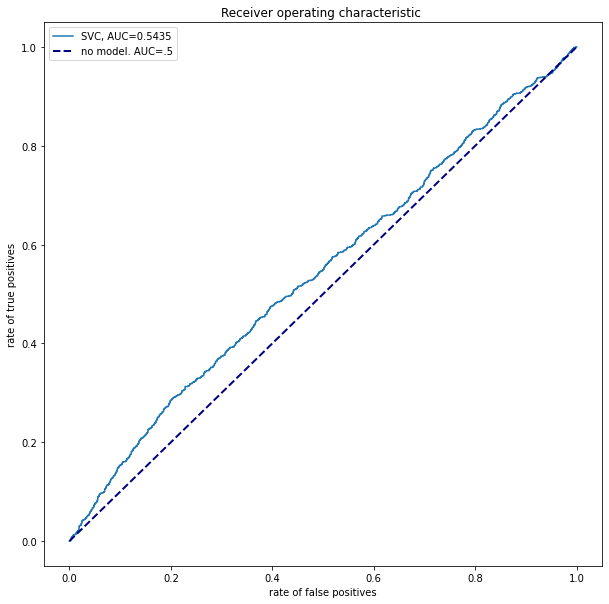



0.09% of the good stories are rightly identified.
0.19% of the bad stories are identified as good ones.


No feature importance


In [97]:
clf_svc_gen_tr = display_model_results(SVC(probability=True, verbose=True), 
                      X_train_gen_tr, X_test_gen_tr, y_train, y_test, 
                      'SVC')


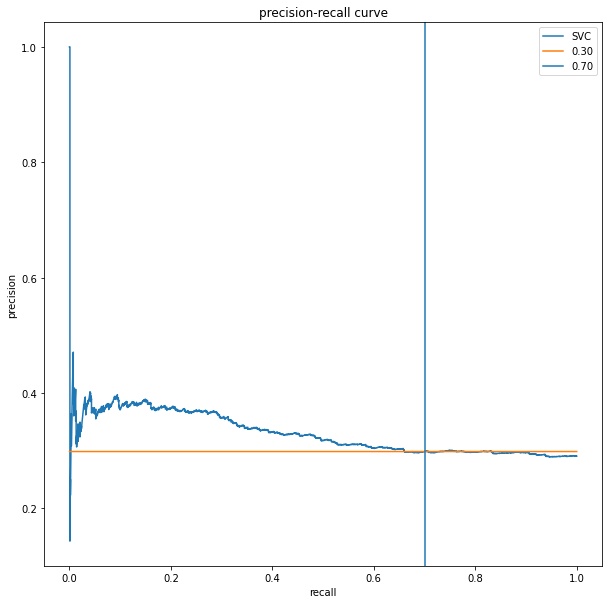



When recall is equal to 0.70, precision is equal to 0.2982,and the threshold is equal to 0.27.
f1 is equal to 0.4182


In [99]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_gen_tr, y_test, 
                                  clf_svc_gen_tr, 'SVC')

In [100]:
conf_matrix(clf_svc_gen_tr, p_threshold, X_test_gen_tr, y_test)

69.94% of the good stories are rightly identified.
67.25% of the bad stories are identified as good ones.


Confusion matrix when p=0.27:
[[ 849 1743]
 [ 318  740]]


### Random Forest

R2 on train set: 0.7549664337580491
R2 on test set: 0.706027397260274


              precision    recall  f1-score   support

           0       0.71      0.98      0.83      2592
           1       0.40      0.03      0.05      1058

    accuracy                           0.71      3650
   macro avg       0.55      0.51      0.44      3650
weighted avg       0.62      0.71      0.60      3650



Confusion matrix:
[[2548   44]
 [1029   29]]




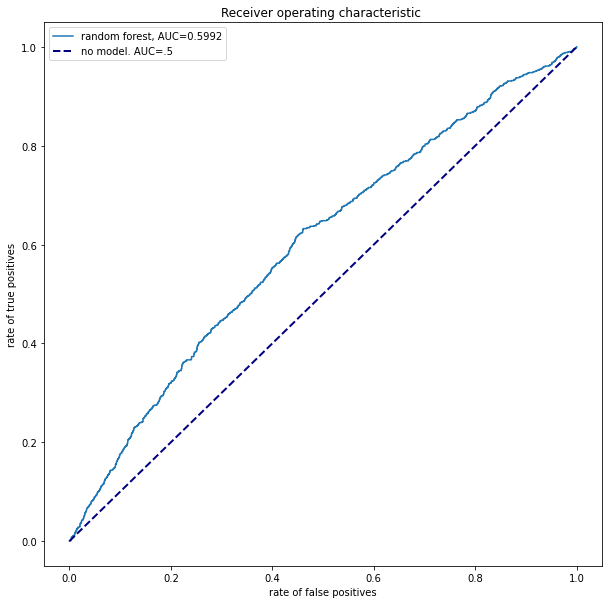



2.74% of the good stories are rightly identified.
1.70% of the bad stories are identified as good ones.


No feature importance


In [107]:
clf_rf_gen_tr = display_model_results(RandomForestClassifier(max_depth=10), 
                      X_train_gen_tr, X_test_gen_tr, y_train, y_test, 
                      'random forest')


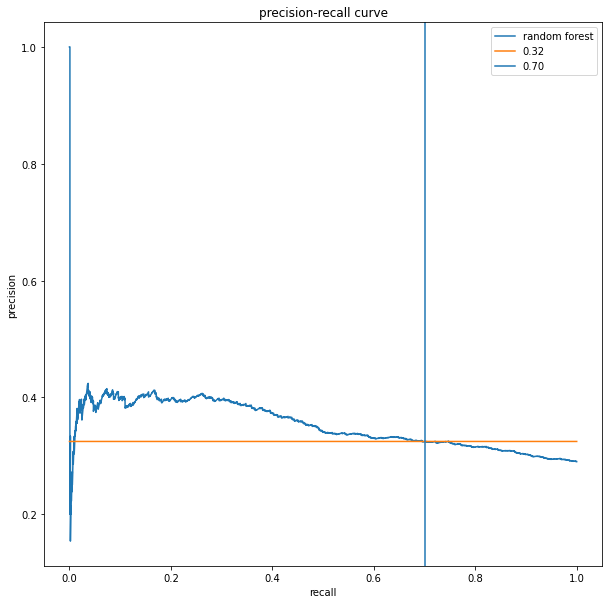



When recall is equal to 0.70, precision is equal to 0.3245,and the threshold is equal to 0.25.
f1 is equal to 0.4434


In [103]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_gen_tr, y_test, 
                                  clf_rf_gen_tr, 'random forest')

In [104]:
conf_matrix(clf_rf_gen_tr, p_threshold, X_test_gen_tr, y_test)

69.94% of the good stories are rightly identified.
59.49% of the bad stories are identified as good ones.


Confusion matrix when p=0.25:
[[1050 1542]
 [ 318  740]]


### HistGradientBoostingClassifier

R2 on train set: 0.72290724756816
R2 on test set: 0.7082191780821918


              precision    recall  f1-score   support

           0       0.71      0.99      0.83      2592
           1       0.43      0.02      0.04      1058

    accuracy                           0.71      3650
   macro avg       0.57      0.51      0.43      3650
weighted avg       0.63      0.71      0.60      3650



Confusion matrix:
[[2562   30]
 [1035   23]]




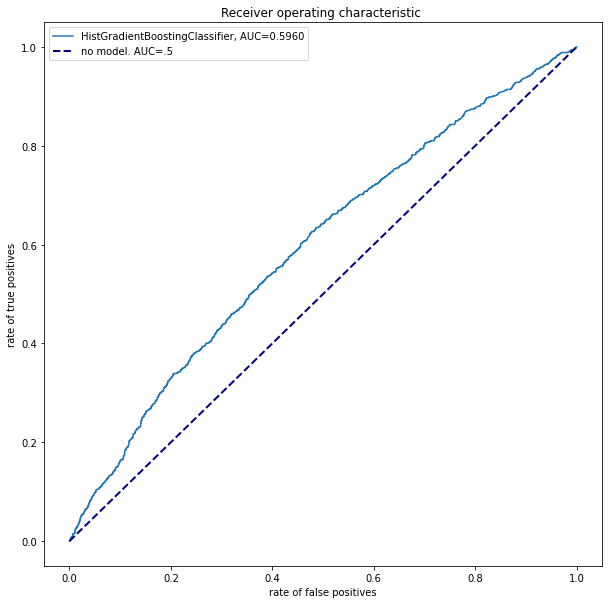



2.17% of the good stories are rightly identified.
1.16% of the bad stories are identified as good ones.


No feature importance


In [90]:
from sklearn.ensemble import HistGradientBoostingClassifier
clf_hist_gen_tr = display_model_results(HistGradientBoostingClassifier(max_iter=10000), 
                      X_train_gen_tr, X_test_gen_tr, y_train, y_test, 
                      'HistGradientBoostingClassifier')

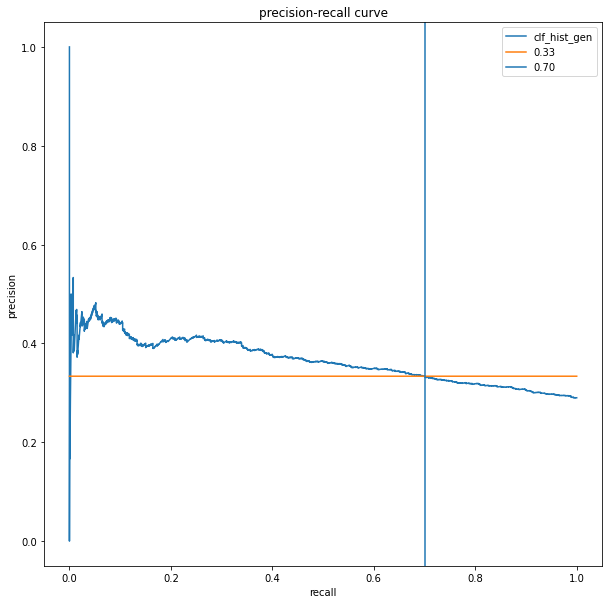



When recall is equal to 0.70, precision is equal to 0.3336,and the threshold is equal to 0.25.
f1 is equal to 0.4519


In [91]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_gen_tr, y_test, clf_hist_gen_tr, 'clf_hist_gen')

In [92]:
conf_matrix(clf_hist_gen_tr, p_threshold, X_test_gen_tr, y_test)

69.94% of the good stories are rightly identified.
57.02% of the bad stories are identified as good ones.


Confusion matrix when p=0.25:
[[1114 1478]
 [ 318  740]]


### AdaBoost

R2 on train set: 0.716056994108782
R2 on test set: 0.7027397260273973


              precision    recall  f1-score   support

           0       0.71      0.97      0.82      2592
           1       0.38      0.04      0.07      1058

    accuracy                           0.70      3650
   macro avg       0.55      0.51      0.45      3650
weighted avg       0.62      0.70      0.61      3650



Confusion matrix:
[[2523   69]
 [1016   42]]




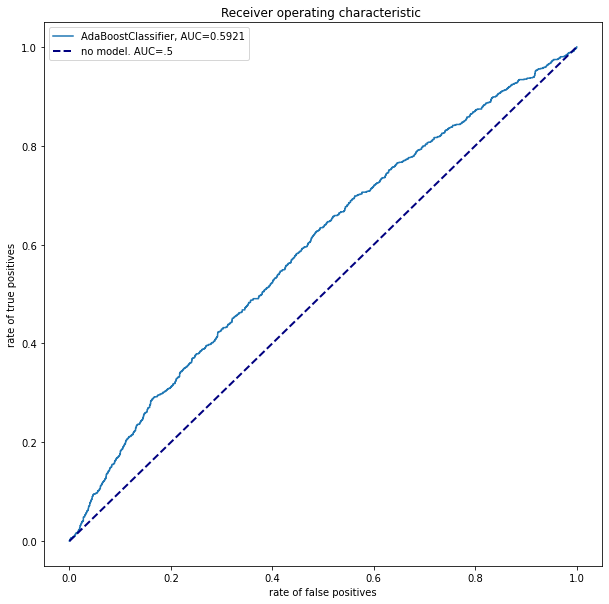



3.97% of the good stories are rightly identified.
2.66% of the bad stories are identified as good ones.


No feature importance


In [87]:
from sklearn.ensemble import AdaBoostClassifier
clf_ada_gen_tr = display_model_results(AdaBoostClassifier(n_estimators=100), 
                      X_train_gen_tr, X_test_gen_tr, y_train, y_test, 
                      'AdaBoostClassifier')


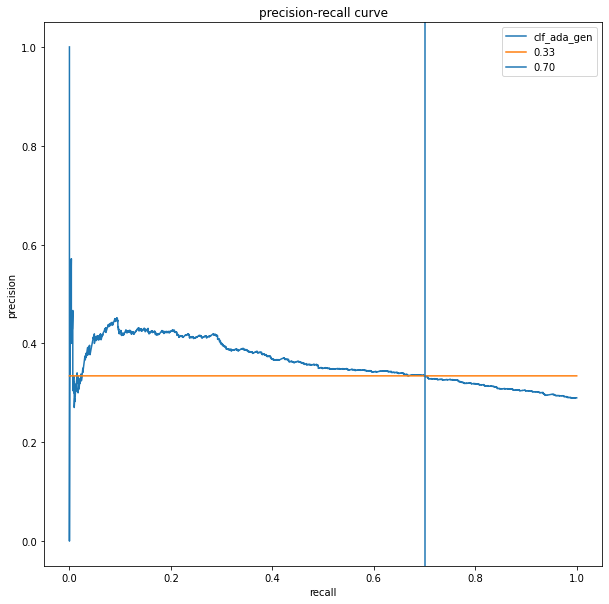



When recall is equal to 0.70, precision is equal to 0.3344,and the threshold is equal to 0.50.
f1 is equal to 0.4526


In [88]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_gen_tr, y_test, clf_ada_gen_tr, 'clf_ada_gen')

In [89]:
conf_matrix(clf_ada_gen_tr, p_threshold, X_test_gen_tr, y_test)

70.04% of the good stories are rightly identified.
56.91% of the bad stories are identified as good ones.


Confusion matrix when p=0.50:
[[1117 1475]
 [ 317  741]]


# ROCs

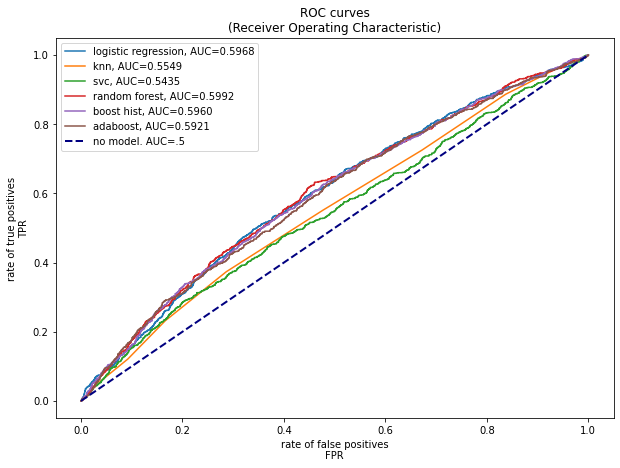

In [108]:
names = ['logistic regression', 'knn', 'svc', 'random forest', 'boost hist', 'adaboost']
models = [clf_log_gen_tr, clf_knn_gen_tr, clf_svc_gen_tr, clf_rf_gen_tr, clf_hist_gen_tr, clf_ada_gen_tr]
plot_rocs(names, models, X_test_gen_tr, y_test)